Code to simulate two state voter model on networks of varying incoherence 

In [12]:
using LightGraphs, GraphIO, GraphPlot, NetworkDynamics, OrdinaryDiffEq, Plots, LightGraphs, Printf


#f=open("net_celegans_neural.dat")




In [13]:
using LinearAlgebra, IterativeSolvers, Statistics
#Function which calculates Trophic Level

function get_levels(A)
    
    A= convert(Array{Float64}, A)
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
   
    
    u = w_in + w_out 
    
    v= w_in - w_out 
   
    Lambda=  diagm(u)-  A - transpose(A)
    
   
    Lambda[1,1]= 0 
    
    h= bicgstabl(Lambda, v, 10)
    #h=  lsmr(Lambda, v)   
       
    h= h .- minimum(h)
    
    return h
end

get_levels (generic function with 1 method)

In [14]:
#Function to calculate Trophic Incohrence 


function calc_troph_incoh(A,h)
    
    F=0

    for (x,y,v) in zip(findnz(A)...)
  
    
        F = F + v*(h[y] - h[x] -1 )^2
        
    end
    
    F= F/sum(A)
    
end
    
    
    
    
    

calc_troph_incoh (generic function with 1 method)

In [15]:
#Update function for voter model

function voter_model_update(x,g,N)
    
    
    x_old= copy(x)
        for i in 1:N
        
        in_connections= inneighbors(g,i)
        
        
        
        if isempty(in_connections)== false
            
            
            
        v = rand(in_connections)
        
        x[i] = x_old[v]
    
        #if x[i]==0
            #x[i]= sign(rand() - 0.5)
        #end
            
            else
            
            #x[i]= sign(rand() - 0.5 )
            x[i]= x_old[i]
        end
    end
    
    return x
end

voter_model_update (generic function with 1 method)

maj_vote_update (generic function with 1 method)

In [17]:
using LinearAlgebra, OrdinaryDiffEq, Random
using Arpack

#setting up network number and size of network N

number=200

N=500

#Update per network

updates= 100

#Range of T control paramater can be linear or log 


#T_list= LinRange(0.025, 8, number)

T_list= 10 .^ (range(-2,stop=2,length=number))


#T_list= 1.2*ones(number)

B=0

F_list = zeros(0)




#Number of edges 

L_targ = 5*N

stop= 2*N^2

eig_list= zeros(0)

r_list= zeros(0)

state_list = zeros(0)


#stop = 5

#w_in=1

for n in 1:number
   
    println(n)
    
    
    g = SimpleDiGraph(N)
    
    #Intial Graph to add edges to 

   
    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Calculate Probablities of Adding edges 

    
    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2) + 0.00000000000001
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #More Effieciemt sampling of probabilities of edges addition 

        
    count=0
    
    
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

#Get basic data.  
    
    
h = get_levels(A)
    
F= calc_troph_incoh(A,h)    
append!( F_list, F )  
    
#println(maximum(real(eigvals(Matrix(A)))))

    
append!( eig_list, maximum(real(eigvals(Matrix(A))))  )  

g= SimpleDiGraph((A))    
    
    
#Set-up intial conditions
    
#x0 =  zeros(0) 
    
#frac=  0.*maximum(h) 
frac= floor(Int,0.05*N)
    
#for i in 1:N
        
      #append!(x0, (sign(h[i] - frac )) ) 
        
        
    #end

sorted = (sortperm(h))    
    
#x0 = sign.(h .- frac)
    
    
x0= ones(N)
   
    
for b in 1:frac
  
    x0[sorted[b]]= -1
    
    
    println(h[sorted[b]])
    end

    
x= x0 

#Run update loop.

for i in 1:updates
        
     voter_model_update(x,g,N)
        
        
        
    end
        
        
        
    
append!(state_list, sum(x))    
    
    
    
    
 
end



println(F_list)




1
0.0
6.09876593671288e-11
8.303224774408591e-11
9.089262675843202e-11
1.1883116712851916e-10
0.9999999999030429
0.999999999929253
0.9999999999325482
0.9999999999955378
1.0000000000076277
1.0000000000539462
1.0000000000609877
1.9999999993833963
1.999999999437767
1.9999999996320792
1.9999999999071054
2.0000000000243983
2.000000000095243
2.000000000107544
2.9999999972957667
2.9999999985996215
2.999999999438744
2.9999999995597424
3.0000000000645723
3.0000000008034906
2
0.0
7.267555446333063e-9
1.0177910070297003e-8
1.1332714322520587e-8
1.6280660375400657e-8
1.90134166189182e-8
2.0087455254724773e-8
2.0714058024395854e-8
2.1050675869105362e-8
2.1858381771266977e-8
2.3257744174998152e-8
2.549730915291093e-8
1.000000017676129
1.0000000178300397
1.0000000203939141
1.0000000242424996
1.0000000243830804
1.0000000265439066
1.000000027948806
1.0000000290657418
1.0000000321977218
1.000000036154674
2.0000000272886034
2.0000000301576435
2.000000032578976
3
0.0
4.50150849928832e-9
7.871296503481062e

0.0
5.622194265697544e-9
8.560821385117379e-9
2.1996207522079203e-8
2.2647206776582607e-8
2.539388077593685e-8
2.6161330879403977e-8
3.448764474001109e-8
3.476559484738573e-8
3.769225997984904e-8
4.114689033940522e-8
4.350504312355952e-8
4.8773284078151846e-8
5.336799091537614e-8
6.167329758000051e-8
7.126025636239319e-8
8.443961974080594e-8
0.9999999949334857
1.0000000053571227
1.0000000116340004
1.0000000242477327
1.0000000248744811
1.0000000262729962
1.000000029788957
1.0000000313626387
19
0.0
3.494124989344982e-9
4.341031978327692e-9
5.921564572020088e-9
6.102760519155481e-9
6.386524642465474e-9
6.60947341302176e-9
6.738406277406739e-9
6.855163103836048e-9
7.004115065711858e-9
7.186459871633133e-9
7.264906010107097e-9
7.33577465439339e-9
7.902181131669295e-9
8.132889472989291e-9
8.483948210624703e-9
8.762544467799671e-9
8.786975147501153e-9
9.004286205538392e-9
9.15718390004372e-9
9.50273815192304e-9
9.940265055519149e-9
1.1632855567711431e-8
1.2341872857035696e-8
1.688497075491568

0.0
2.383480079970468e-10
6.608189551116084e-10
1.0338645495266974e-9
1.104908164961671e-9
1.1059668736379535e-9
1.3605472304334398e-9
1.7823218456669565e-9
2.3383996961001685e-9
2.7988669160095014e-9
3.0345965740252723e-9
3.0471269951704016e-9
3.2705358421480923e-9
3.530754355551835e-9
4.487120008889178e-9
0.9999999956076806
0.9999999980022913
0.9999999983117043
0.9999999989775503
0.9999999990537027
0.9999999995162128
0.999999999522224
0.9999999999519318
1.0000000005658194
1.0000000014313315
36
0.0
2.4798900710720773e-9
2.6834179323032004e-9
2.9397853040791233e-9
3.563073391887883e-9
3.994813368990435e-9
4.419042909376003e-9
4.73353978236446e-9
4.8026755905539176e-9
6.8039049949675245e-9
7.121272460608452e-9
7.898353970858807e-9
1.0242150239037073e-8
0.9999999920685845
0.9999999927714462
0.99999999383272
0.999999993844316
0.9999999942722688
0.9999999944989781
0.9999999975116438
0.9999999975478779
0.9999999988869455
0.9999999997715818
1.0000000009715428
1.0000000041758774
37
0.0
7.7446

0.0
0.13552767193195514
0.1464271665222494
0.16307588312101817
0.16523722423860043
0.1657817662507748
0.1669413582703969
0.1677533748293225
0.16796617440664452
0.17636726578999085
0.1770547577418755
0.1804372635951932
0.25461113818986014
1.1518221168303517
1.153780400809854
1.1543847133359009
1.1547466092428218
1.1549070210966166
1.156888570970243
1.1572948766274402
1.1629211433078614
1.1630387827197195
1.1648419611316143
1.1660335326845033
1.1667185060292953
54
0.0
0.005289475970030821
0.006271549077748517
0.006828061482174519
0.01078415588564674
0.011894275622202244
0.013004394436514133
0.033147537116615666
0.06754931744567116
0.07530575740341305
0.15061151560527009
0.9228568206979642
0.995565873500869
1.0027688179583727
1.0044105521683822
1.0055253860841429
1.0188888997882568
1.536734167768433
1.9558602689892481
1.9710781517103122
1.9981809482374953
2.000132045782168
2.0013332988623773
2.982971674614145
2.9888637153430953
55
0.0
0.0008747731927041258
0.003564191010429596
0.004436765

0.0
0.09105293270700443
0.10645828953801661
0.14867872386674463
0.16655439657170845
0.22059566052484136
0.23295760450169745
0.33071411742301393
1.018915362187709
1.0459145383605453
1.0600529180910652
1.0615962696446317
1.0665782785214226
1.089660657768512
1.091684670931416
1.1780002799989173
1.2016042811562286
1.2426126894211809
1.2553028812664557
1.6393318221688027
1.6932604550892503
1.789667572888698
1.8992802724462887
1.9055903807867125
1.9622165548124624
72
0.0
0.1157198559847501
0.1227727766724982
0.17461052089575446
0.19302037392129634
0.20832820894145243
0.22894389282997096
0.2520377308271051
0.8513195850936448
0.9391342113001357
0.9494450267858419
0.973161427263868
1.0945234939213186
1.1008067839881157
1.1020017715857229
1.1236723017040937
1.1551463983965071
1.1955536960609763
1.1985110454664678
1.2756758370153136
1.2929136997879738
1.3963614405916474
1.7314578759369468
1.762731729500807
1.9168216582107078
73
0.0
0.09505141864769229
0.15970871916208296
0.25930835701226584
0.664

0.0
0.28601811386164044
0.37354173804309454
0.40970173734119086
0.6717027780657929
0.9008102802338591
1.1134260345135445
1.2951956315756057
1.428078822050928
1.4483526037998544
1.5676600225091946
1.5755927979655624
1.709209429788043
1.9758154847995364
2.2328977199242104
2.236154585421005
2.479482817448254
2.500526893065377
2.5995349374500947
2.905888020026566
2.931157653993221
3.0136442967407895
3.3090932883707254
3.3725884453177954
3.650660414960619
90
0.0
0.0458567110095236
0.0736996632321143
0.09060220310134515
0.18842683084002076
0.39253408519105415
0.5623570290911026
0.7343030030607656
0.8539060992124019
0.8810439426970824
1.0029234633105737
1.1990126037124167
1.2533861155021113
1.3497973174560278
1.4465960490322605
1.449487234678036
1.492055519209462
1.633700791522347
1.6641840343479681
1.8232235978603994
1.9782867768285983
2.0006280475761975
2.004646986476504
2.0112765833973665
2.1786939700536565
91
0.0
0.11954401204339149
0.1491055379509305
0.17706393156425193
0.294723387427144

0.0
0.14821081948959303
0.16665227943549188
0.2814527888495839
0.29443761944613933
0.46426517825799096
0.5258007762763457
0.538334747780105
0.5560581841970975
0.5691634847497342
0.5701946327097489
0.7494099149187382
0.7847460584251926
0.8137191657438978
0.8208420364943575
0.832491519599767
0.8383626903459758
0.8541550980091401
0.8886766530121997
0.9198388505628045
0.9715795485064154
0.977623703168899
0.9781234176273538
1.0956293528627479
1.1007920504257562
108
0.0
0.23855290010379981
0.3795358504485371
0.381911251175449
0.477105801875636
0.6385528997095928
0.7999999992484632
1.0325597510491384
1.3457337558069113
1.6855836532854234
1.7999999974430736
2.1781842155218243
2.853133211181886
3.010634675699565
3.1781842154531645
3.8330370419244915
4.020682769969911
4.655439408431091
4.746548654468225
5.472414538898734
5.477841775177142
6.267934530510759
6.318059440604366
6.452493010194365
6.669933721165181
109
0.0
0.18165298532276086
0.2610612343826335
0.38075580097455863
0.5091573498958342
0

0.0
0.36701662588500916
0.4617948926833506
0.4630457054286836
0.7081427771421147
0.7255326884066342
0.8201154893103801
0.8461447690548631
0.8575746300093137
0.988013962281709
1.0486303150826153
1.1051153110640453
1.308313577775193
1.3473448806010406
1.3526354860081131
1.4373579472817468
1.4515688626285534
1.4984145031376723
1.6054430913956015
1.6311592095688923
1.6327271915498187
1.6981143633804727
1.712057937837752
1.7437592470330294
1.7975853728951527
126
0.0
0.10083219511955566
0.16772119420362097
0.1868289853532894
0.23889608412452068
0.24644715513478088
0.30035431109645305
0.35163056917602864
0.3518913511560502
0.3561337261546309
0.35679087952138167
0.35725036954720224
0.3585569060427223
0.3741707154316716
0.400312062254371
0.415092666168968
0.41615274669524815
0.4245571952953249
0.4672880809493922
0.469912323815906
0.4736641474812886
0.5248693339926283
0.5269438293462045
0.5295171193400288
0.5519450954478502
127
0.0
0.10034480507104115
0.1329183443444686
0.13724383874199564
0.150

0.0
2.0894486141287416e-10
2.091340434162703e-10
0.9999999992340922
1.0000000002060951
1.8678736170424832
1.9996767930415693
2.1324495866019815
2.360257580919342
2.5574703276404454
2.7473897100427735
2.781548181968704
2.8346477740504827
2.8545189285719728
2.8687297233909272
2.9559112648200863
2.9878356769717347
2.999353586754596
3.0281703757174374
3.1006700015653528
3.1245019330073154
3.1872031323650063
3.1930392684736915
3.1990003729973435
3.2165331412717126
144
0.0
0.0017926106182963863
0.9315422823013528
0.9964147788412081
1.075628160201703
1.7601323200121204
1.8104155394771615
1.8612919540470578
1.8893602544796368
1.9031536197500984
1.9197159566381248
1.9928295577791033
2.0147693325910914
2.047635363901061
2.0502719681202235
2.14946370965214
2.2035536353100005
2.2116977140598735
2.244574191575975
2.3311218031968792
2.358691631216107
2.382189595634496
2.4097371612454266
2.437839477652823
2.462783703630615
145
0.0
0.08869366706739568
0.10877209301836133
0.1250299078726529
0.142276499

0.0
0.024166639135084433
0.14872057568789565
0.18944892791984957
0.2212668976181253
0.24714124013720845
0.2808064660336852
0.3044384075066593
0.32411150565688635
0.3661432714812389
0.372103719976594
0.37506517895337105
0.37526417477804297
0.3766977869241603
0.38071120794556546
0.39819285587678277
0.401828766349068
0.41153934564867656
0.4171027831421085
0.4273223758087749
0.4289752205995146
0.44558507072193404
0.45321720748017746
0.4546385881057155
0.47170606530817927
162
0.0
0.1655976822011933
0.19950183018297096
0.32623502134116
0.34202202901467826
0.3421155762701411
0.379946619155481
0.4126574300623851
0.42058697184411153
0.4362164821593053
0.4550935464798953
0.4695034767983892
0.4948052210826539
0.5053704375003436
0.5189775776222967
0.5217169077405441
0.5229663915262375
0.542474932960272
0.5583650559383897
0.6741888710264703
0.7192978511517945
0.721650870369219
0.7365519459581442
0.7443728627644364
0.7452080954683569
163
0.0
0.12528351804122573
0.1525696579673277
0.315465654139665
0

0.0
0.10294066469194235
0.18553395942357698
0.19946513272675515
0.21218531081053965
0.2131836266904804
0.231333674978691
0.3178855650025284
0.33932844483805474
0.3544152053971227
0.3818225875746973
0.38295487367589615
0.3950170849447627
0.41938870515298843
0.4278907649792263
0.4467346652329358
0.45038262079185376
0.4720610663972242
0.4872764520921602
0.5003370989443389
0.5187612588811562
0.5230379945779939
0.530302257965865
0.5380816210495006
0.5455699662601694
180
0.0
0.0381245190937638
0.06625652046796748
0.06966013732058851
0.0749751172280928
0.13548737529317378
0.16283760642583833
0.20819827969057214
0.21779084733255893
0.22728363408260233
0.24843145446888837
0.25684523062992515
0.26974280337325784
0.27816141440130693
0.27894874849081375
0.2799767486693052
0.32698474911329467
0.3270502795266683
0.3273951726053259
0.33503658059165087
0.3371724042891786
0.3399565003829361
0.34909538025796216
0.3509425592363553
0.3614750136033258
181
0.0
0.057276589266964995
0.18354287058151625
0.2216

0.0
0.08090931454182781
0.10468630332059148
0.10926350998746903
0.11294811627839463
0.13132462321097932
0.14829006586021576
0.18039429757203418
0.20312967050531056
0.21803442032090758
0.28291001621366246
0.28374583530362124
0.3021712851469185
0.303003395466753
0.31013234648606103
0.3105122207688032
0.31182998179743576
0.32079272479245263
0.3246834856755719
0.3362331626894856
0.34937572417679125
0.3517642468547308
0.35609557011593795
0.36221324128668564
0.3662099762568669
198
0.0
0.23994670035354504
0.24995187880740566
0.29451947002454815
0.30629774251551944
0.31212567885905707
0.3196766385326548
0.3411064895315812
0.3498910056399508
0.3506365863519971
0.3512703888645574
0.36513650988866164
0.3680717546466384
0.3688236902968827
0.3708624590995779
0.38375613570287703
0.3879484126073718
0.4043102288823943
0.4043969836427359
0.40869937182146004
0.41815499377084697
0.4186292140130847
0.41994374866452533
0.42543392727257906
0.4272338865791708
199
0.0
0.03385125293125424
0.10848872075627103
0

Plotting the results.

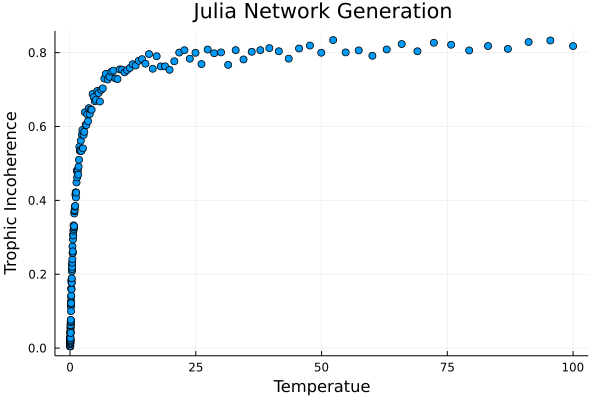

In [18]:
using Plots

plot(T_list,F_list, seriestype = :scatter, legend = false, xlabel= "Temperatue",

ylabel="Trophic Incoherence", title= "Julia Network Generation")

#savefig("Julia_generation_log_space.pdf")

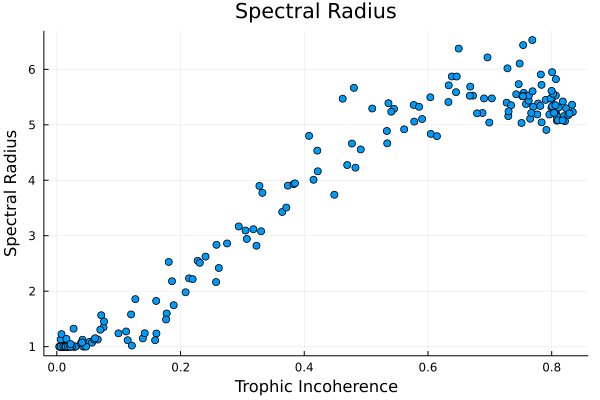

In [19]:
#println(eig_list)

plot(F_list, eig_list, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Spectral Radius", title= "Spectral Radius")


#savefig("Julia_generation_Spec_radius_logspace_2.pdf")

In [23]:
plot(F_list, state_list/N, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Average State of System", title= "Voter Model", ylim=(-1.05,1.05))


#savefig("Voter_model__N_500_lowest_5_percent_test.pdf")

In [21]:
plot(F_list, cos.(phase_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Cosine of Average Phase", title= "Final Phase when the lowest tenth modified")

#savefig("Kuramoto_0.1_controls_dynamics_2.pdf")

LoadError: UndefVarError: phase_list not defined

In [22]:
plot(eig_list, r_list, seriestype = :scatter, legend = false, xlabel= "Spectral Radius",

ylabel="R Phase Coherence", title= "Oscillator Synchronization Spectral Radius")

DivideError: DivideError: integer division error